# 05 Propensity Score

Recall the exchangeability assumption requires that $\mathbb P(A=1|C=c)=\mathbb P(A=0|C=c)$ for all confounding variables $c\in C$. But, it does not usually hold in observation studies. We can use propensity score to adjust for the confounding variables.

## Propensity Score

Define the propensity score:

$$e(c) = \mathbb P(A=1|C=c).$$

In particular, if the exchangeability assumption holds, we have $e(c)=\frac12$ for all $c\in C$.

### Estimation

In practice, we first fit a logistic regression model to estimate the propensity score:

$$e(c) = \frac{1}{1+\exp(\beta_0 + \beta^Tc)}.$$

In [46]:
# Thanks to data from
# https://github.com/linxy29/HW_casual-inference/blob/e5f10cbf50b97d0e37a0df2486caac5c7e39c26d/gardasil.dat
import pandas as pd
import numpy as np
data = pd.read_csv('./data/gardasil.dat', sep = '\t')
print('Length of data =', len(data))
print('Types of race =', set(data['Race']))
print('Types of insurance =', set(data['InsuranceType']))
print('Types of location =', set(data['Location']))
print('Types of outcome =', np.unique(data['PracticeType'], return_counts = True))
data.head()

Length of data = 1413
Types of race = {0, 1, 2, 3}
Types of insurance = {0, 1, 2, 3}
Types of location = {1, 2, 3, 4}
Types of outcome = (array([0, 1, 2], dtype=int64), array([515, 365, 533], dtype=int64))


,Age,AgeGroup,Race,Shots,Completed,InsuranceType,MedAssist,Location,LocationType,PracticeType,Unnamed: 10,Unnamed: 11
0,21,1,0,3,1,3,0,1,0,1,NaN,NaN
1,21,1,0,3,1,3,0,1,0,1,NaN,NaN
2,20,1,0,1,0,1,0,1,0,1,NaN,NaN
3,14,0,0,3,1,3,0,1,0,0,NaN,NaN
4,17,0,3,2,0,3,0,1,0,1,NaN,NaN


In [47]:
# fit propensity score with variables:
# Age, Race, InsuranceType, Location
import numpy as np

# extract race, insurance, location and convert to dummy variables
n = len(data)
dummies = {'Race': np.zeros((n,4)), 'InsuranceType': np.zeros((n,4)), 'Location': np.zeros((n,4))}
for key in dummies.keys():
    x = data[key]
    y = dummies[key]
    if key == 'Location': x = x - 1
    for i in range(n):
        y[i, x[i]] += 1

# discard the first column of each dummy variable to avoid multicollinearity
for key in dummies.keys():
    dummies[key] = dummies[key][:,1:]

# concatenate the dummy variables
X = np.concatenate([data['Age'].values.reshape(-1,1)] + list(dummies.values()), axis = 1)

In [48]:
# using statsmodels to fit propensity score
import statsmodels.api as sm

# as the outcome has 3 types, we need to fit 3 models
# as an example, we only fit the first model
y = (data['PracticeType'] != 0).values.astype('float')

family = sm.families.Binomial(link = sm.families.links.logit())
model = sm.GLM(y, sm.add_constant(X), family = family).fit()

# Warning: the result shows that x8, x9 have very large standard errors
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1413
Model:                            GLM   Df Residuals:                     1402
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -369.73
Date:                Tue, 02 May 2023   Deviance:                       739.46
Time:                        11:32:43   Pearson chi2:                     801.
No. Iterations:                    25   Pseudo R-squ. (CS):             0.5455
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0074      0.676    -13.326      0.000     -10.332      -7.683
x1             0.5576      0.037     14.978      0.000       0.485       0.631
x2            -0.3040      0.219     -1.385      0.166      -0.734       0.126
x3            -0.4442      0.642     -0.692      0.489      -1.702       0.814
x4            -0.0709      0.257     -0.276      0.783      -0.574       0.433
x5             0.7489      0.323      2.317      0.020       0.116       1.382
x6             1.3975      0.497      2.810      0.005       0.423       2.372
x7             0.4117      0.358      1.151      0.250      -0.289       1.113
x8            24.4358    2.3e+04      0.001      0.999   -4.51e+04    4.51e+04
x9            24.6145   3.07e+04      0.001      0.999   -6.01e+04    6.02e+04
x10           -2.8134      0.288     -9.767      0.000      -3.378      -2.249
==============================================================================
"""

In [110]:
# since x8, x9 have large standard errors, we can exclude them
# exclude x8, x9 and refit the model
X2 = np.concatenate([X[:,:7], X[:,9:]], axis = 1)
model2 = sm.GLM(y, sm.add_constant(X2), family = family).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1413
Model:                            GLM   Df Residuals:                     1404
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -396.17
Date:                Tue, 02 May 2023   Deviance:                       792.34
Time:                        12:29:14   Pearson chi2:                     883.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5282
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6051      0.650    -13.238      0.000      -9.879      -7.331
x1             0.5808      0.037     15.793      0.000       0.509       0.653
x2            -0.4566      0.212     -2.153      0.031      -0.872      -0.041
x3            -0.5817      0.633     -0.920      0.358      -1.821       0.658
x4            -0.3203      0.255     -1.255      0.209      -0.821       0.180
x5             0.4470      0.289      1.546      0.122      -0.120       1.014
x6             1.3123      0.470      2.792      0.005       0.391       2.234
x7            -0.2641      0.321     -0.822      0.411      -0.894       0.365
x8            -3.4065      0.278    -12.274      0.000      -3.950      -2.863
==============================================================================
"""

### Comparable Units

For each unit (subject) with confounding variable $c$, we shall compute the estimated $e(c)$ by the fitted logistic regression model. When $e(c)$ is close to $1$ or close to $0$, it indicates that almost all the units with $c$ are treated or untreated. In this case, the treatment assignment is not balanced and the unit is not comparable. We should exclude these units from the analysis.

We could plot the $e(c)$ for each treated and untreated units. We maintain the data with overlapped $e(c)$ while excluding the data with extreme $e(c)$. After trimming the data, we can re-fit a logistic regression model, estimate the propensity score and check overlap, and repeat the process until the data are balanced.

We can eliminate treatment with propensity higher than the highest control, and eliminate control with propensity lower than the lowest treatment.

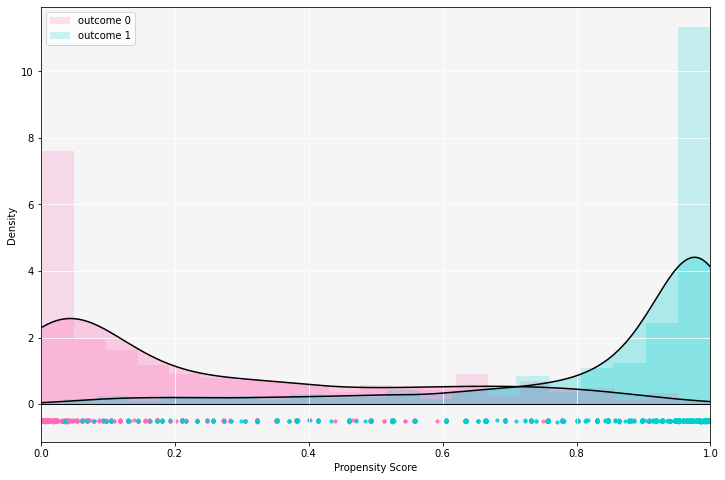

In [112]:
from matplotlib import pyplot as plt
# predict the propensity score for each subject
ps = model2.predict(sm.add_constant(X2))
ps_data = pd.DataFrame({'ps': ps, 'y': y})

def plot_pscore(ps_data, figsize = (12, 8), colors = ('HotPink', 'DarkTurquoise')):
    plt.figure(figsize = figsize)
    for outcome, color in zip(range(2), colors):
        part_data = ps_data[ps_data['y'] == outcome]

        # plot the density curve of propensity score of the class
        ax = part_data['ps'].plot.density(color = 'black', label = '_nolegend_')
        curve = ax.get_lines()[-1]
        plt.fill_between(curve.get_xdata(), curve.get_ydata(), color = color, alpha = .3)

        # plot the histogram of propensity score of the class
        plt.hist(part_data['ps'].values, density = True, bins = 20,
            color = color, label = 'outcome %s'%(outcome), alpha = 0.2)
    
        # mark the propensity score of every individual
        plt.scatter(part_data['ps'].values, np.random.normal(0, 0.01, len(part_data)) - .5, s = 10, color = color, alpha = 0.8)

    plt.legend()
    plt.xlim(0, 1)
    plt.plot([0, 1], [0, 0], color = 'black', linestyle = '-', linewidth = 1)
    plt.xlabel('Propensity Score')
    plt.grid(color = 'white')
    plt.gca().set_facecolor('#F5F5F5')
    plt.show()

plot_pscore(ps_data)

Trim data to reserve propensity between (0.0353, 0.9527).
Rest of data = 799 / 1413 (56.55%)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  799
Model:                            GLM   Df Residuals:                      790
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.07
Date:                Tue, 02 May 2023   Deviance:                       774.14
Time:                        13:45:51   Pearson chi2:                     771.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3371
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5300      0.693    -10.869      0.000      -8.888      -6.172
x1             0.5084      0.041     12.546      0.000       0.429       0.588
x2            -0.4103      0.209     -1.965      0.049      -0.820      -0.001
x3            -0.4832      0.635     -0.761      0.446      -1.727       0.761
x4            -0.3042      0.253     -1.200      0.230      -0.801       0.193
x5             0.4175      0.284      1.471      0.141      -0.139       0.974
x6             1.1557      0.470      2.460      0.014       0.235       2.077
x7            -0.2253      0.315     -0.715      0.475      -0.843       0.392
x8            -3.0444      0.286    -10.652      0.000      -3.605      -2.484
==============================================================================
"""

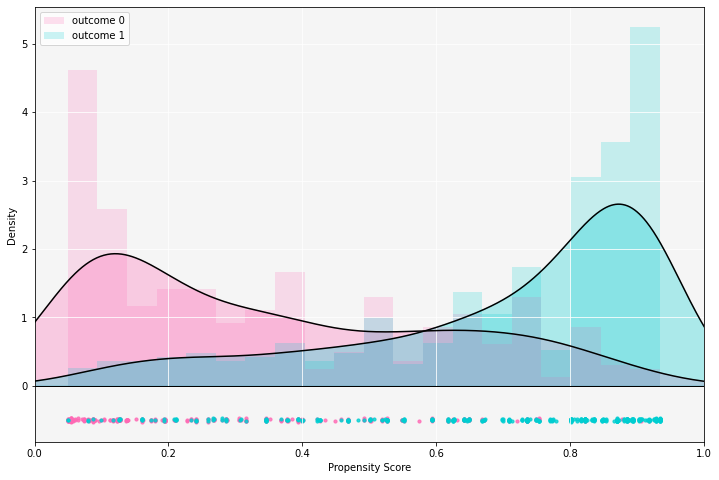

Trim data to reserve propensity between (0.0498, 0.9337).
Rest of data = 799 / 799 (100.00%)


In [158]:
from IPython.display import display
def trim_overlap(X, ps_data):
    trim_bound = (ps_data[ps_data['y'] == 1]['ps'].min(), ps_data[ps_data['y'] == 0]['ps'].max())
    ps = ps_data['ps'].values
    inds = np.extract((ps >= trim_bound[0]) & (ps <= trim_bound[1]), np.arange(len(ps)))
    X_trim, y_trim = X[inds], y[inds]
    print('Trim data to reserve propensity between (%.4f, %.4f).'%(trim_bound[0], trim_bound[1]))
    print('Rest of data = %d / %d (%.2f%%)'%(len(X_trim), len(X), len(X_trim) / len(X) * 100))
    return X_trim, y_trim, inds, trim_bound

X2_trim, y2_trim, trim_inds, trim_bound = trim_overlap(X2, ps_data)

# fit the model again
model3 = sm.GLM(y2_trim, sm.add_constant(X2_trim), family = family).fit()
display(model3.summary())
ps3 = model3.predict(sm.add_constant(X2_trim))
ps_data3 = pd.DataFrame({'ps': ps3, 'y': y2_trim})
plot_pscore(ps_data3)

[trim_overlap(np.copy(X2_trim), ps_data3), None][1] # show that after the first trimming, the data are balanced

## Covariate Balance

Apart from propensity score $\mathbb P(A|C)$, we shall guarantee that the covariate $\mathbb P(C|A)$ is balanced across
treatment and control groups. 

### SMD

We can use the standardized mean difference (SMD) to measure the balance. It is also known as Cohen's d effect size.
Ref: [[Formula](https://support.sas.com/resources/papers/proceedings12/335-2012.pdf)] [[Code](https://cran.r-project.org/web/packages/tableone/vignettes/smd.html)]

For numerical variable $X_i$ with treatment $A_i\in\{0,1\}$, it is defined by 
$$\text{SMD}(X) = \frac{\bar X_1 - \bar X_0}{\sqrt{\frac{s_1^2+s_0^2}{2}}}$$
where $\bar X_a$ and $s_a^2$ are the sample mean and variance of $X_i$ with $A_i=a$.

<br>

SMD evaluates the difference of distribution of covariates between treatment and control groups. We wish to see $\text{SMD}<0.2$ in practice.

In [269]:
import pandas as pd
import numpy as np
def _smd(data, y, categorial = False):
    """Standard mean difference (SMD), also known as Cohen's d.
    NOTE: it seems this implementation is different from R package 'tableone'.
    """
    x1, x0 = data[y == 1], data[y == 0]
    if not categorial:
        var1, var0 = x1.var(ddof = 1), x0.var(ddof = 1)
        pooled_var = (var1 + var0) / 2
        return (x1.mean() - x0.mean()) / pooled_var**.5
    else:
        classes = set(data.values)
        x1 = np.array([(x1 == c).sum() for c in classes])
        x0 = np.array([(x0 == c).sum() for c in classes])
        x1, x0 = x1 / x1.sum(), x0 / x0.sum()

        def _sd(x1, x0):
            x1, x0 = x1.reshape((-1, 1)), x0.reshape((-1, 1))
            S = x1 @ x1.T + x0 @ x0.T
            S.flat[::S.shape[0]+1] = (x1 * (1 - x1) + x0 * (1 - x0)).flatten() # diag
            S /= 2.
            diff = x1 - x0
            return ((diff.T @ np.linalg.solve(S, diff)) ** .5)[0,0]

        smd = []
        for c in (0,):
            # choose c as baseline variable
            x1c = np.concatenate([x1[:c], x1[c+1:]])
            x0c = np.concatenate([x0[:c], x0[c+1:]])
            smd.append(_sd(x1c, x0c))
        return np.array(smd).mean()

def check_balance(data, keys, is_categorical, column_y):
    index_names = ['n']
    summaries = {0: [], 1: [], 'SMD': ['']}
    for outcome in range(2):
        part_data = data[data[column_y] == outcome]
        summaries[outcome].append(len(part_data))
    for key, categorial in zip(keys, is_categorical):
        summaries['SMD'].append(_smd(data[key], data[column_y], categorial = categorial))
        if categorial:
            index_names.append('%s (%%)'%key)
            classes = set(part_data[key].values)
            index_names += ['%s'%c for c in classes]
            for outcome in range(2):
                part_data = data[data[column_y] == outcome]
                summary = summaries[outcome]
                summary.append('') # leave the first row blank
                for c in classes:
                    count = (part_data[key] == c).sum()
                    summary.append('%d (%.2f)'%(count, count / len(part_data) * 100))
            summaries['SMD'] += [''] * len(classes)
        else:
            index_names.append('%s (SD)'%key)
            for outcome in range(2):
                part_data = data[data[column_y] == outcome]
                summary = summaries[outcome]
                summary.append('%.2f (%.2f)'%(part_data[key].mean(), part_data[key].std(ddof = 1)))

    return pd.DataFrame(summaries, index = index_names)

# concatenate y to data
data_with_y = pd.concat([data, pd.DataFrame({'y': y})], axis = 1)
print('Covariate balance before trimming:')
check_balance(data_with_y, ['Age', 'Race', 'InsuranceType', 'Location'], [False, True, True, True], 'y')

Covariate balance before trimming:


,0,1,SMD
n,515,898,
Age (SD),14.92 (2.25),20.63 (3.67),1.876732
Race (%),,,0.282276
0,232 (45.05),500 (55.68),
1,194 (37.67),249 (27.73),
2,29 (5.63),23 (2.56),
3,60 (11.65),126 (14.03),
InsuranceType (%),,,0.685484
0,204 (39.61),71 (7.91),
1,171 (33.20),552 (61.47),


In [272]:
# the covariates are more balanced after trimming (lower SMD)
check_balance(data_with_y.iloc[trim_inds], ['Age', 'Race', 'InsuranceType', 'Location'], [False, True, True, True], 'y')

,0,1,SMD
n,368,431,
Age (SD),15.71 (2.08),17.70 (2.71),0.824861
Race (%),,,0.112162
0,171 (46.47),221 (51.28),
1,133 (36.14),137 (31.79),
2,12 (3.26),10 (2.32),
3,52 (14.13),63 (14.62),
InsuranceType (%),,,0.312299
0,103 (27.99),47 (10.90),
1,133 (36.14),215 (49.88),


### Strata

We can stratify the units by estimated propensity score, i.e. clustering units with similar propensity score. Then we check the covariate balance in each stratum.

### Inference

If the estimated ACE (average causal effect) in stratum $j$ is denoted by $\widehat{\text{ACE}}_j$, then the overall ACE is given b
$$\widehat{\text{ACE}} = \sum_j \widehat{\text{ACE}}_j \frac{N_j}{N}$$
where $N_j$ is the number of units in stratum $j$ and $N$ is the total number of units.

The estimated variance of $\widehat{\text{ACE}}$ is given by
$$\widehat{\text{Var}}(\widehat{\text{ACE}}) = \sum_j \frac{N_j^2}{N^2}\left(\frac{s_{1,j}^2}{N_{1,j}} + \frac{s_{0,j}^2}{N_{0,j}}\right)$$
where $s_{a,j}^2$ is the sample variance of $Y_i$ with $A_i=a$ in stratum $j$.